In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
!pip install tensorflow==2.3.0
!pip install tensorflow-datasets==3.2.1
!pip install Pillow==7.2.0

     |████████████████████████████████| 320.4MB 50kB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
     |████████████████████████████████| 460kB 22.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


     |████████████████████████████████| 3.4MB 7.9MB/s 
  Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1
     |████████████████████████████████| 2.2MB 8.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [1]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                               include_top=False,
                               weights=None)# Your Code Here

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  # Your Code Here
    layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

# Expected Output is extremely large, but should end with:

#batch_normalization_v1_281 (Bat (None, 3, 3, 192)    576         conv2d_281[0][0]                 
#__________________________________________________________________________________________________
#activation_273 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_273[0][0] 
#__________________________________________________________________________________________________
#mixed9_1 (Concatenate)          (None, 3, 3, 768)    0           activation_275[0][0]             
#                                                                 activation_276[0][0]             
#__________________________________________________________________________________________________
#concatenate_5 (Concatenate)     (None, 3, 3, 768)    0           activation_279[0][0]             
#                                                                 activation_280[0][0]             
#__________________________________________________________________________________________________
#activation_281 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_281[0][0] 
#__________________________________________________________________________________________________
#mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_273[0][0]             
#                                                                 mixed9_1[0][0]                   
#                                                                 concatenate_5[0][0]              
#                                                                 activation_281[0][0]             
#==================================================================================================
#Total params: 21,802,784
#Trainable params: 0
#Non-trainable params: 21,802,784

--2020-12-24 09:13:43--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   246MB/s    in 0.3s    

2020-12-24 09:13:44 (246 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                    

In [3]:
last_layer = pre_trained_model.get_layer("mixed7")
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output# Your Code Here

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

last layer output shape:  (None, 7, 7, 768)


In [4]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

      

In [5]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

model.summary()

# Expected output will be large. Last few lines should be:

# mixed7 (Concatenate)            (None, 7, 7, 768)    0           activation_248[0][0]             
#                                                                  activation_251[0][0]             
#                                                                  activation_256[0][0]             
#                                                                  activation_257[0][0]             
# __________________________________________________________________________________________________
# flatten_4 (Flatten)             (None, 37632)        0           mixed7[0][0]                     
# __________________________________________________________________________________________________
# dense_8 (Dense)                 (None, 1024)         38536192    flatten_4[0][0]                  
# __________________________________________________________________________________________________
# dropout_4 (Dropout)             (None, 1024)         0           dense_8[0][0]                    
# __________________________________________________________________________________________________
# dense_9 (Dense)                 (None, 1)            1025        dropout_4[0][0]                  
# ==================================================================================================
# Total params: 47,512,481
# Trainable params: 38,537,217
# Non-trainable params: 8,975,264


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [6]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

--2020-12-24 09:13:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   114MB/s    in 1.2s    

2020-12-24 09:13:49 (114 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-12-24 09:13:49--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 172.253.117.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148

In [7]:
# Define our example directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir, "horses")
train_humans_dir = os.path.join(train_dir, "humans")
validation_horses_dir = os.path.join(validation_dir, "horses")
validation_humans_dir = os.path.join(validation_dir, "humans")

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

# Expected Output:
# 500
# 527
# 128
# 128

500
527
128
128


In [8]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    fill_mode='nearest',
                                    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=10,
                                                    class_mode='binary')     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150,150),
                                                        batch_size=10,
                                                        class_mode='binary')

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [9]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 97% accuracy

callbacks = myCallback()# Your Code Here
history = model.fit_generator(train_generator,
                              epochs=50,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks=[callbacks])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
103/103 [==============================] - 12s 120ms/step - loss: 0.0776 - acc: 0.9640 - val_loss: 0.0315 - val_acc: 0.9844
Epoch 2/50
103/103 [==============================] - 11s 109ms/step - loss: 0.0187 - acc: 0.9942 - val_loss: 0.0090 - val_acc: 0.9961
Epoch 3/50
103/103 [==============================] - 11s 110ms/step - loss: 0.0038 - acc: 0.9990 - val_loss: 0.0177 - val_acc: 0.9922
Epoch 4/50
103/103 [==============================] - 11s 109ms/step - loss: 0.0021 - acc: 0.9990 - val_loss: 0.0886 - val_acc: 0.9805
Epoch 5/50
103/103 [==============================] - 11s 109ms/step - loss: 0.0208 - acc: 0.9961 - val_loss: 0.0348 - val_acc: 0.9922
Epoch 6/50
103/103 [==============================] - 11s 109ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 0.9961
Epoch 7/50
103/103 [==============================] - 11s 110ms/step - loss: 0.0047 - acc: 0.9990 - val_loss: 0.00

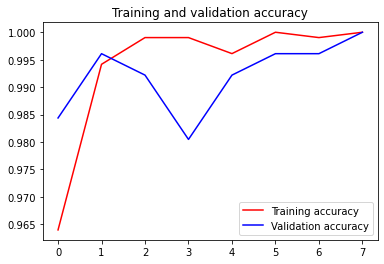

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [12]:
model.save("model_week3.h5")